In [1]:
#Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###Data Handling

In [2]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
])

In [3]:
#Downloading the dataset
train_data = torchvision.datasets.FashionMNIST(root = 'data',train = True,transform = transforms.ToTensor(), download = True)
train_set , val_set = torch.utils.data.random_split(train_data, [0.8, 0.2])
test_set = torchvision.datasets.FashionMNIST(root = 'data', train = False, transform = transforms.ToTensor())

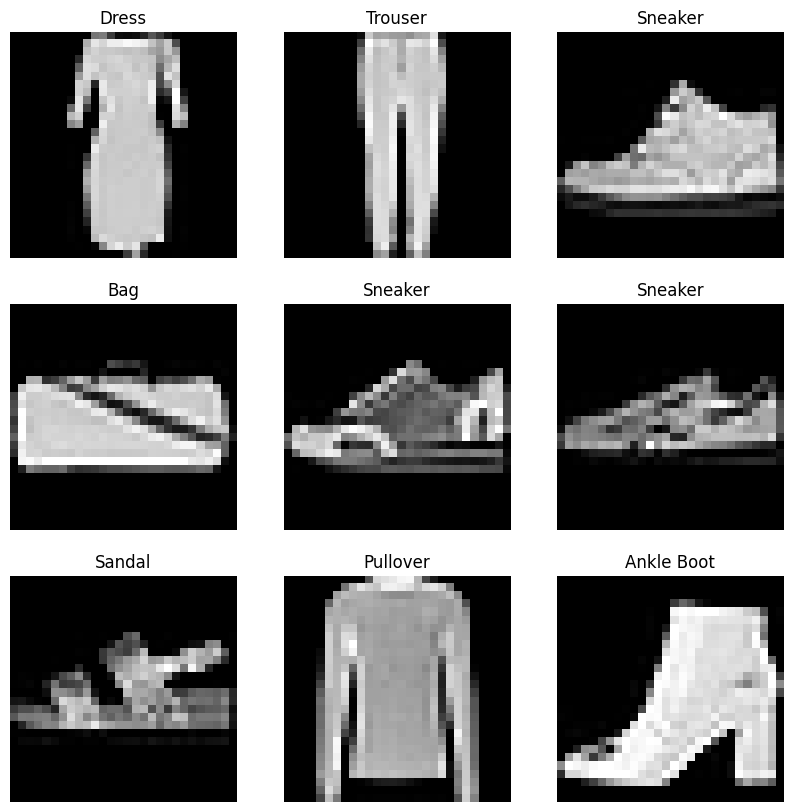

In [4]:
#visualizing the dataset
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

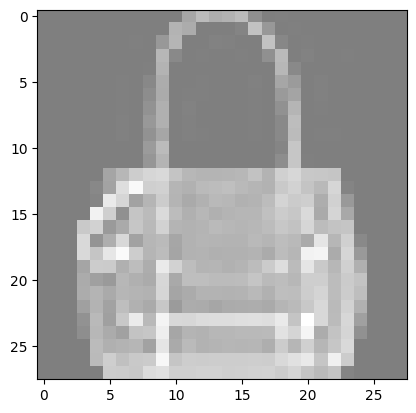

In [5]:
#Visualizing a single data point
dataiter = iter(train_set)

# Get a batch of training images and labels
images, labels = next(dataiter)

# Function to unnormalize and plot images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [6]:
#Preparing the dataLoaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 64, shuffle=False, num_workers=1)

print(len(test_set))

10000


###CNN Model with predefined 4 Blocks

In [7]:
class CNN(nn.Module):
    def __init__(self, input_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #Block 1 with convolution layer, activation func and maxpool layer
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2), #Block 2
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2), #Block 3
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2), #Block 4
        )

        self.out = nn.Linear(in_features=128*(28 // 2**4) * (28 // 2**4), out_features= 10) # nn.Linear creates a single layer

    #forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

### Loss function and optimizer

In [8]:
#Define model
model = CNN(input_channels=1).cuda()

#Loss fuction
criterion = nn.CrossEntropyLoss()

#Optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [10]:
model_children = list(model.children())

In [11]:
model_children[0]

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [12]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


###Training, Validation and Testing fuctions

In [13]:
train_Loss = []
def train(num_epochs, model, loaders ):

    model.train()

    for epoch in range(num_epochs):
        train_loss = 0
        for i, (images, labels) in enumerate(loaders):

            images = images.cuda()
            labels = labels.cuda()
            output = model(images)[0]
            loss = criterion(output, labels) #calulating the loss

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_Loss.append(train_loss/ len(train_loader))# append average loss per epoch in a train_Loss list

    return train_Loss






val_Loss = []
def val():
    # Validate the model
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)[0]
            val_output, last_layer = model(images)
            loss = criterion(output , labels)
            val_loss += loss.item()


            pred_y = torch.max(val_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0)) #Using accuracy as metrics for comparison

    val_Loss.append(val_loss/ len(val_loader)) # append val loss in val_Loss list
    print('Validation Accuracy of the model on the test images: %.2f' % accuracy)

    return val_Loss




test_Loss = []
def test():
    # Test the model
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        test_loss = 0
        correct = 0

        total = 0

        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)[0]

            test_output, last_layer = model(images)

            loss = criterion(output , labels)
            test_loss += loss.item()


            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0)) #Using accuracy as metrics for comparison


            #Confusion matrix
            pred_labels = test_output.argmax(1)
            correct += (pred_labels == labels).type(torch.float).sum().item()

            all_preds.extend(pred_labels.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_targets , all_preds)

    plt.figure(figsize = (10,8))
    sns.heatmap(cm, annot=True, fmt= "d", cmap = "viridis", xticklabels=test_loader.dataset.classes, yticklabels= test_loader.dataset.classes)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    test_Loss.append(test_loss/ len(test_loader)) # append test loss in val_Loss list
    print('Test Accuracy of the model on the test images: %.2f' % accuracy)

    return test_Loss




In [14]:
model_children[0].parameters()

<generator object Module.parameters at 0x7cf26539daf0>

###Greedy training

[2.3048996982574463, 2.304874757130941, 2.3048499689102173, 2.304825527826945, 2.304801456451416]
Validation Accuracy of the model on the test images: 0.03
[2.3050431583790068]


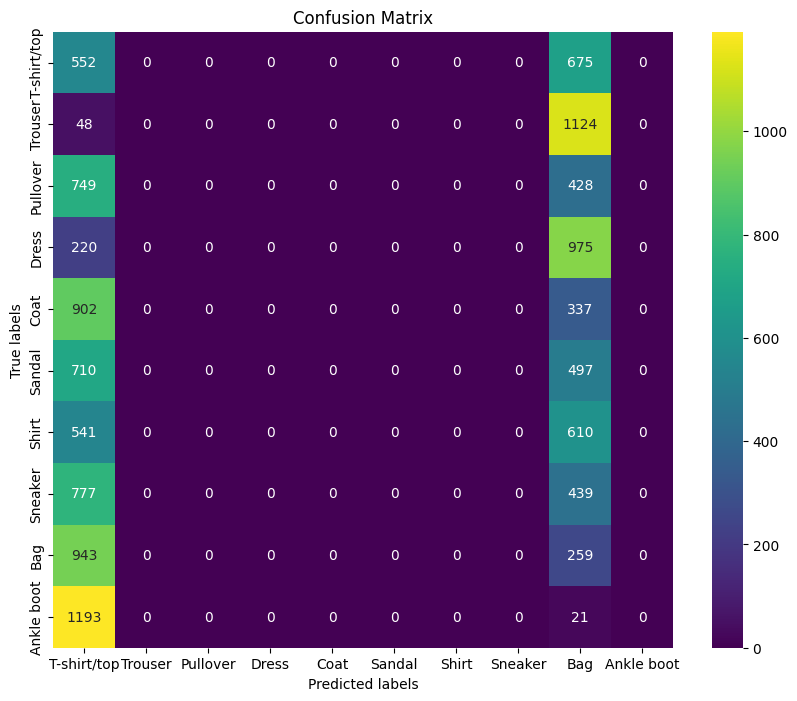

Test Accuracy of the model on the test images: 0.03
[2.7601790686321865]


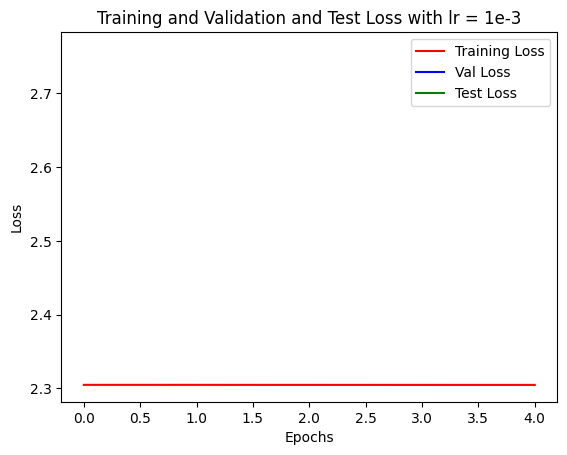

[2.304442363103231, 2.3037386061350507, 2.3029951680501304, 2.302287276903788, 2.301643426895142]
Validation Accuracy of the model on the test images: 0.06
[2.3050431583790068, 2.301532879788825]


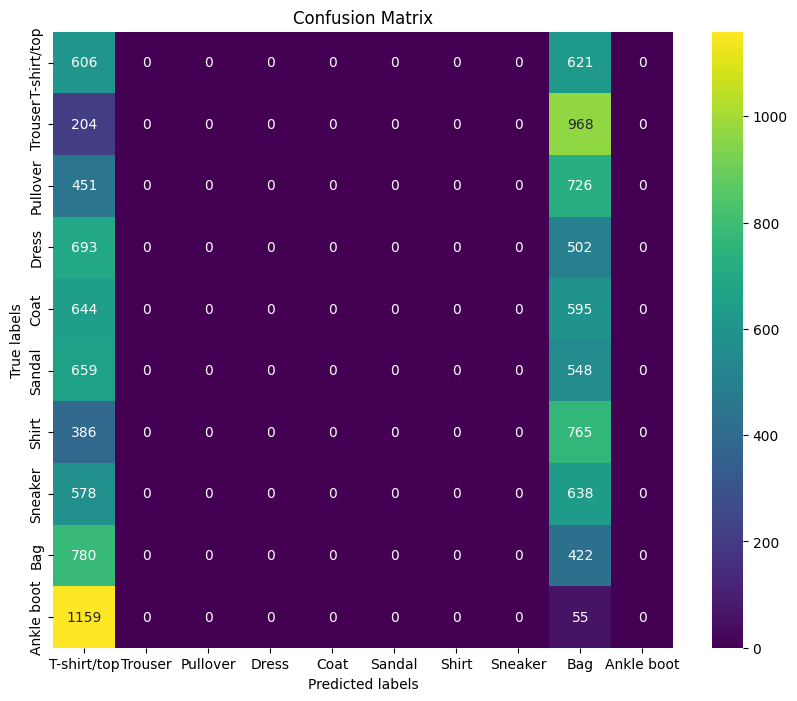

Test Accuracy of the model on the test images: 0.06
[2.7559756777089115]


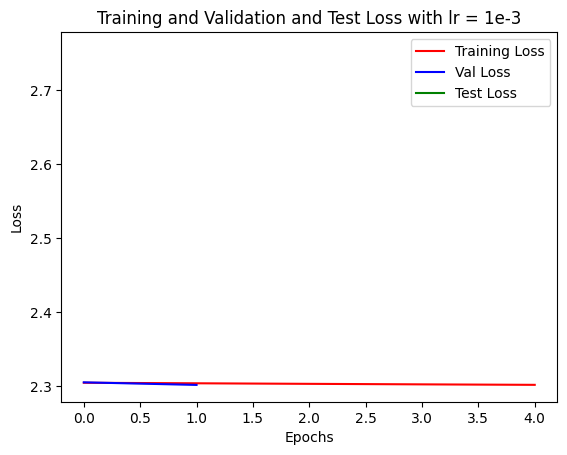

[2.300378487586975, 2.298581144014994, 2.297033704439799, 2.2956701666514077, 2.2944154043197633]
Validation Accuracy of the model on the test images: 0.12
[2.3050431583790068, 2.301532879788825, 2.294003283723872]


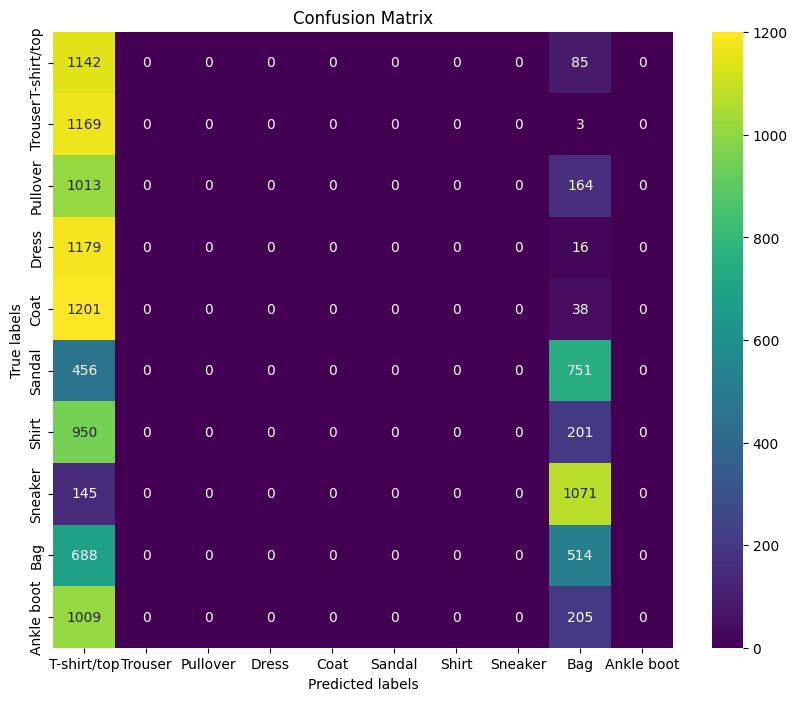

Test Accuracy of the model on the test images: 0.12
[2.7469593461152093]


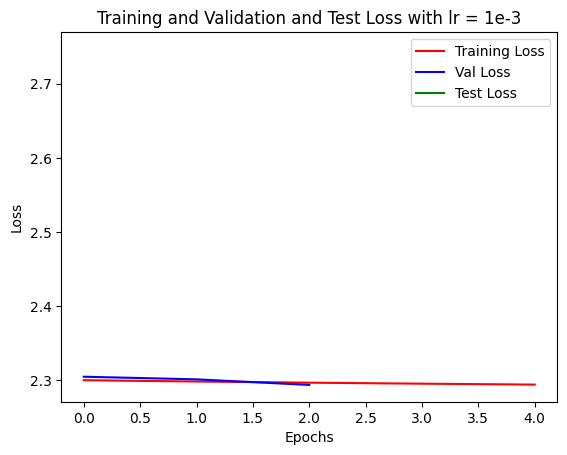

[2.29169863541921, 2.288311001141866, 2.285356511751811, 2.282568593343099, 2.2798772700627645]
Validation Accuracy of the model on the test images: 0.16
[2.3050431583790068, 2.301532879788825, 2.294003283723872, 2.2787593387542886]


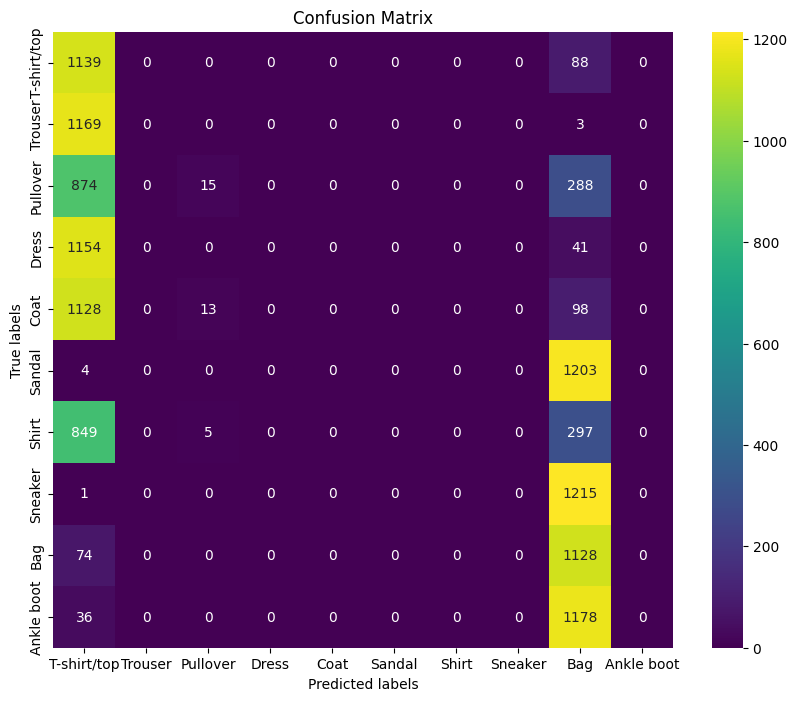

Test Accuracy of the model on the test images: 0.16
[2.7287054502280657]


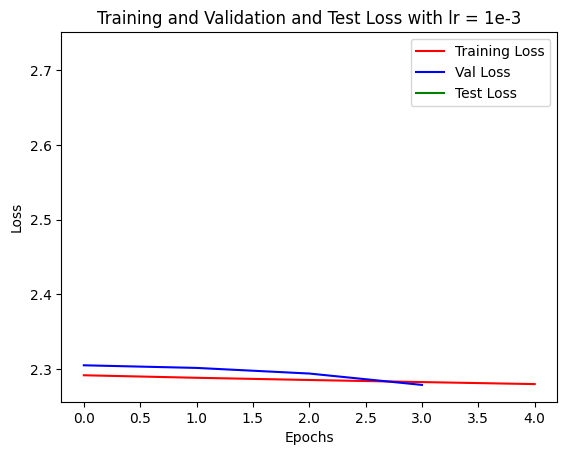

In [15]:

for i in range(4): #loop for freezing layers one by one

    for param in model_children[i].parameters(): #Freezes ith layer
        param.requires_grad = True

    train(num_epochs= 5, model = model , loaders = train_loader) #training the model
    print(train_Loss)
    val() #Validate the model
    print(val_Loss)
    test() #test the model
    print(test_Loss)

    #Visualize the loss obtained
    plt.plot(train_Loss, color='r', label='Training Loss')
    plt.plot(val_Loss, color='b', label='Val Loss')

    plt.plot(test_Loss, color='g', label='Test Loss')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation and Test Loss with lr = 1e-3")

    plt.legend()
    plt.show()

    train_Loss = [] # Empty the list so it can store values for another model obtained by freezing another layers
    test_Loss = []






    for param in model.parameters(): # Freezing all the layers again
        param.requires_grad = False


I have used accuracy as a comparison parameter. We can compare the loss plot of Validation loss and Testing loss to determine which layer is more important in the network so we can reduce the complexity of model to get good results.

I have also plotted the confusion matrix heatplot.

By tunning the hyper-parameters we can again improve the accuracy and reduce the loss, I have set the batch size to 64 and lr to 1e-3.

By keeping the layer 1 unfreezed accuracy - 3%
By keeping the layer 2 unfreezed accuracy - 6%
By keeping the layer 3 unfreezed accuracy - 12%
By keeping the layer 4 unfreezed accuracy - 16%

